## 1. Heart disease and potential risk factors
<p>Millions of people develop some sort of heart disease every year and heart disease is the biggest killer of both men and women in the United States and around the world. Statistical analysis has identified many risk factors associated with heart disease such as age, blood pressure, total cholesterol, diabetes, hypertension, family history of heart disease, obesity, lack of physical exercise, etc. In this notebook, we're going to run statistical tests and regression models using the Cleveland heart disease dataset to assess one particular factor -- maximum heart rate one can achieve during exercise and how it is associated with a higher likelihood of getting heart disease.</p>
<p><img src="https://assets.datacamp.com/production/project_445/img/run31.png" height="300" width="300"></p>

In [9]:
# Read datasets Cleveland_hd.csv into hd_data
hd_data <- read.csv("datasets/Cleveland_hd.csv")

# take a look at the first 5 rows of hd_data
head(hd_data, 5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


## 2. Converting diagnosis class into outcome variable
<p>We noticed that the outcome variable <code>class</code> has more than two levels. According to the codebook, any non-zero values can be coded as an "event." Let's create a new variable called <code>hd</code> to represent a binary 1/0 outcome.</p>
<p>There are a few other categorical/discrete variables in the dataset. Let's also convert sex into a 'factor' for next step analysis. Otherwise, R will treat this as continuous by default.</p>
<p>The full data dictionary is also displayed here.</p>
<p><img src="https://assets.datacamp.com/production/project_445/img/datadict.png" height="500" width="500"></p>

In [11]:
# load the tidyverse package
library(tidyverse)

# Use the 'mutate' function from dplyr to recode our data
hd_data %>% mutate(hd = ifelse(class > 0, 1, 0)) -> hd_data

# recode sex using mutate function and save as hd_data
hd_data %>% mutate(sex = factor(sex, levels = 0:1, labels = c("Female", "Male"))) -> hd_data

## 3. Identifying important clinical variables
<p>Now, let's use statistical tests to see which predictors are related to heart disease. We can explore the associations for each variable in the dataset. Depending on the type of the data (i.e., continuous or categorical), we use t-test or chi-squared test to calculate the p-values.</p>
<p>Recall, t-test is used to determine whether there is a significant difference between the means of two groups (e.g., is the mean age from group A different from the mean age from group B?). A chi-squared test for independence compares the equivalence of two proportions.</p>

In [14]:
# Does sex have an effect? Sex is a binary variable in this dataset,
# so the appropriate test is chi-squared test
hd_sex <- chisq.test(hd_data$sex, hd_data$hd)

# Does age have an effect? Age is continuous, so we use a t-test
hd_age <- t.test(hd_data$age, hd_data$hd)

# What about thalach? Thalach is continuous, so we use a t-test
hd_heartrate <- t.test(hd_data$thalach, hd_data$hd)

# Print the results to see if p<0.05.
print(hd_sex)
print(hd_age)
print(hd_heartrate)


	Pearson's Chi-squared test with Yates' continuity correction

data:  hd_data$sex and hd_data$hd
X-squared = 22.043, df = 1, p-value = 2.667e-06


	Welch Two Sample t-test

data:  hd_data$age and hd_data$hd
t = 103.8, df = 303.84, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 52.95685 55.00355
sample estimates:
 mean of x  mean of y 
54.4389439  0.4587459 


	Welch Two Sample t-test

data:  hd_data$thalach and hd_data$hd
t = 113.47, df = 302.29, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 146.5619 151.7351
sample estimates:
  mean of x   mean of y 
149.6072607   0.4587459 



## 4. Explore the associations graphically (i)
<p>A good picture is worth a thousand words. In addition to p-values from statistical tests, we can plot the age, sex, and maximum heart rate distributions with respect to our outcome variable. This will give us a sense of both the direction and magnitude of the relationship.</p>
<p>First, let's plot age using a boxplot since it is a continuous variable.</p>

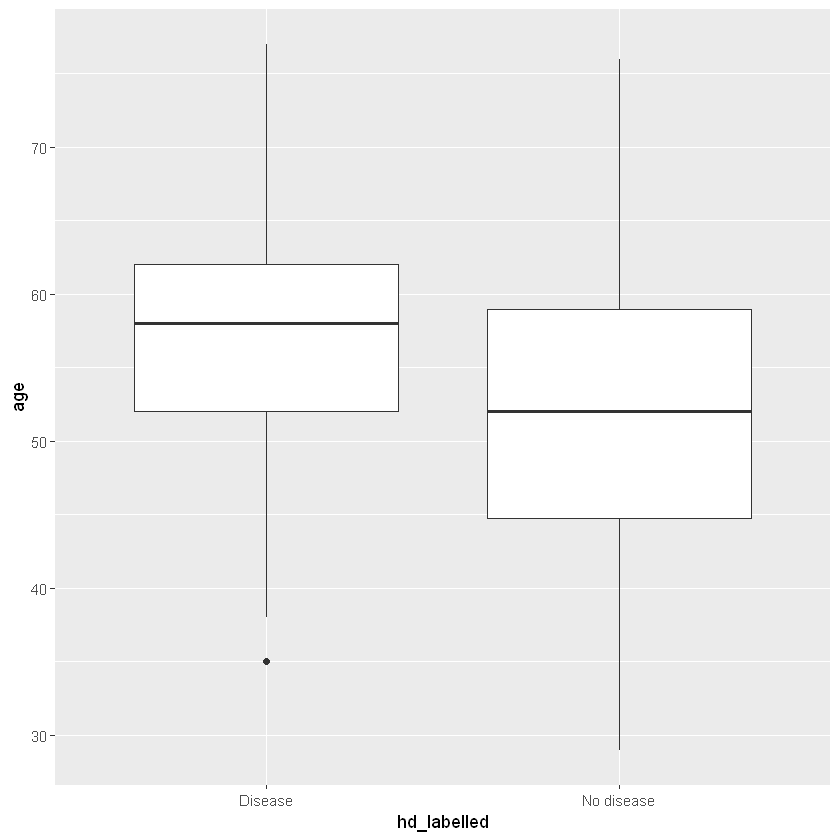

In [15]:
# Recode hd to be labelled
hd_data%>% mutate(hd_labelled = ifelse(hd == 0, "No disease", "Disease")) -> hd_data

# age vs hd
ggplot(data = hd_data, aes(x = hd_labelled,y = age)) + geom_boxplot()

## 5. Explore the associations graphically (ii)
<p>Next, let's plot sex using a barplot since it is a binary variable in this dataset.</p>

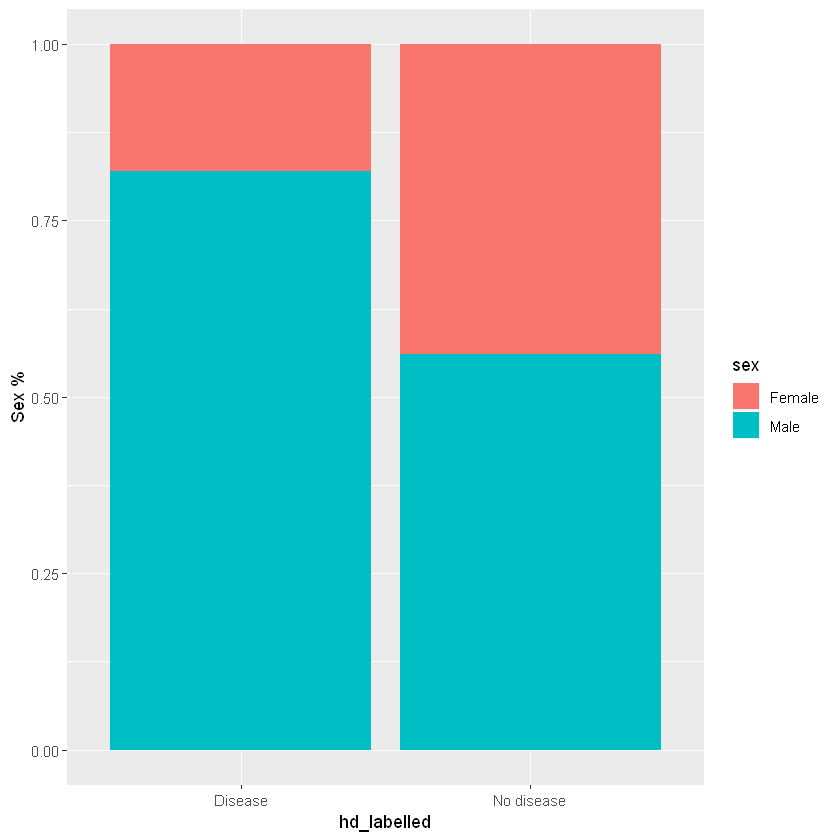

In [17]:
# sex vs hd
ggplot(data = hd_data, aes(x = hd_labelled, fill = sex)) + geom_bar(position = "fill") + ylab("Sex %")

## 6. Explore the associations graphically (iii)
<p>And finally, let's plot thalach using a boxplot since it is a continuous variable.</p>

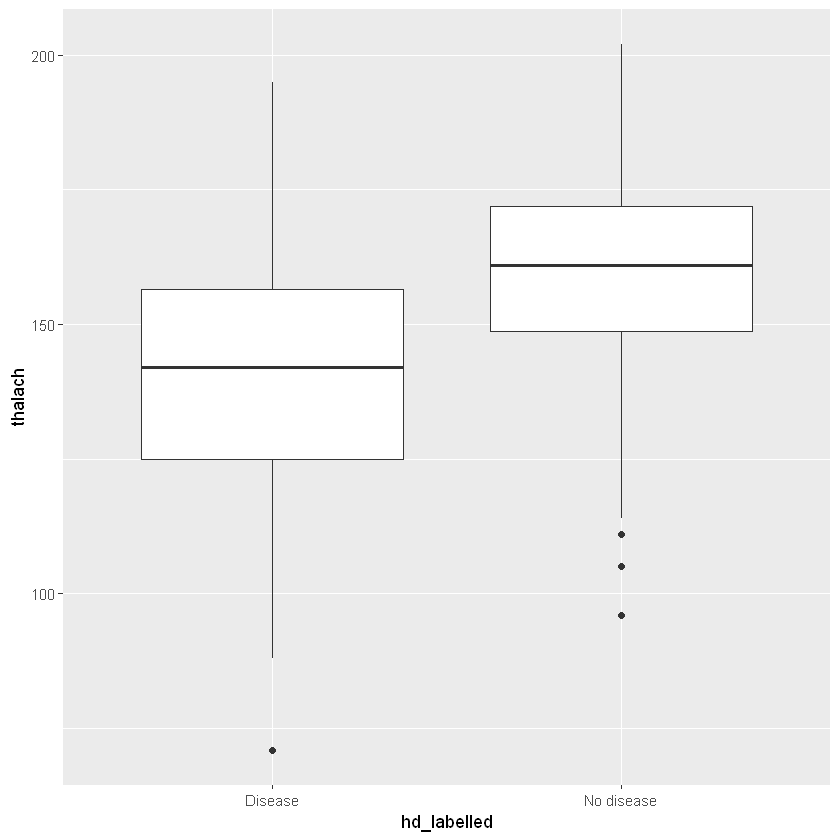

In [18]:
# max heart rate vs hd
ggplot(data = hd_data, aes(x = hd_labelled, y = thalach)) + geom_boxplot()

## 7. Putting all three variables in one model
<p>The plots and the statistical tests both confirmed that all the three variables are highly significantly associated with our outcome (p&lt;0.001 for all tests). </p>
<p>In general, we want to use multiple logistic regression when we have one binary outcome variable and two or more predicting variables. The binary variable is the dependent (Y) variable; we are studying the effect that the independent (X) variables have on the probability of obtaining a particular value of the dependent variable. For example, we might want to know the effect that maximum heart rate, age, and sex have on the probability that a person will have a heart disease in the next year. The model will also tell us what the remaining effect of maximum heart rate is after we control or adjust for the effects of the other two effectors. </p>
<p>The <code>glm()</code> command is designed to perform generalized linear models (regressions) on binary outcome data, count data, probability data, proportion data, and many other data types. In our case, the outcome is binary following a binomial distribution.</p>

In [19]:
# use glm function from base R and specify the family argument as binomial
model <- glm(data = hd_data, hd ~ age + sex + thalach, family = "binomial")

# extract the model summary
summary(model)


Call:
glm(formula = hd ~ age + sex + thalach, family = "binomial", 
    data = hd_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2250  -0.8486  -0.4570   0.9043   2.1156  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.111610   1.607466   1.936   0.0529 .  
age          0.031886   0.016440   1.940   0.0524 .  
sexMale      1.491902   0.307193   4.857 1.19e-06 ***
thalach     -0.040541   0.007073  -5.732 9.93e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 417.98  on 302  degrees of freedom
Residual deviance: 332.85  on 299  degrees of freedom
AIC: 340.85

Number of Fisher Scoring iterations: 4


## 8. Extracting useful information from the model output
<p>It's common practice in medical research to report Odds Ratio (OR) to quantify how strongly the presence or absence of property A is associated with the presence or absence of the outcome. When the OR is greater than 1, we say A is positively associated with outcome B (increases the Odds of having B). Otherwise, we say A is negatively associated with B (decreases the Odds of having B).</p>
<p>The raw glm coefficient table (the 'estimate' column in the printed output) in R represents the log(Odds Ratios) of the outcome. Therefore, we need to convert the values to the original OR scale and calculate the corresponding 95% Confidence Interval (CI) of the estimated Odds Ratios when reporting results from a logistic regression. </p>

In [20]:
# load the broom package
library(broom)

# tidy up the coefficient table
tidy_m <- tidy(model)
tidy_m

# calculate OR
tidy_m$OR <- exp(tidy_m$estimate)

# calculate 95% CI and save as lower CI and upper CI
tidy_m$lower_CI <- exp(tidy_m$estimate - 1.96 * tidy_m$std.error)
tidy_m$upper_CI <- exp(tidy_m$estimate + 1.96 * tidy_m$std.error)

# display the updated coefficient table
tidy_m

term,estimate,std.error,statistic,p.value
(Intercept),3.11161046,1.607466382,1.935724,5.290157e-02
age,0.03188572,0.016439824,1.939541,5.243548e-02
sexMale,1.49190218,0.307192627,4.856569,1.194372e-06
thalach,-0.04054143,0.007072952,-5.731897,9.931367e-09


term,estimate,std.error,statistic,p.value,OR,lower_CI,upper_CI
(Intercept),3.11161046,1.607466382,1.935724,5.290157e-02,22.4571817,0.9617280,524.3946593
age,0.03188572,0.016439824,1.939541,5.243548e-02,1.0323995,0.9996637,1.0662073
sexMale,1.49190218,0.307192627,4.856569,1.194372e-06,4.4455437,2.4346539,8.1173174
thalach,-0.04054143,0.007072952,-5.731897,9.931367e-09,0.9602694,0.9470490,0.9736743


## 9. Predicted probabilities from our model
<p>So far, we have built a logistic regression model and examined the model coefficients/ORs. We may wonder how can we use this model we developed to predict a person's likelihood of having heart disease given his/her age, sex, and maximum heart rate. Furthermore, we'd like to translate the predicted probability into a decision rule for clinical use by defining a cutoff value on the probability scale. In practice, when an individual comes in for a health check-up, the doctor would like to know the predicted probability of heart disease, for specific values of the predictors: a 45-year-old female with a max heart rate of 150. To do that, we create a data frame called newdata, in which we include the desired values for our prediction.</p>

In [0]:
# get the predicted probability in our dataset using the predict() function
pred_prob <- ....(....,...., type = "response")

# create a decision rule using probability 0.5 as cutoff and save the predicted decision into the main data frame
hd_data$.... <- ....

# create a newdata data frame to save a new case information
newdata <- data.frame(age = 45, sex = "Female", thalach = 150)

# predict probability for this new case and print out the predicted value
p_new <- ....(....,...., type = "response")
p_new

## 10. Model performance metrics
<p>Are the predictions accurate? How well does the model fit our data? We are going to use some common metrics to evaluate the model performance. The most straightforward one is Accuracy, which is the proportion of the total number of predictions that were correct. On the other hand, we can calculate the classification error rate using 1- accuracy. However, accuracy can be misleading when the response is rare (i.e., imbalanced response). Another popular metric, Area Under the ROC curve (AUC), has the advantage that it's independent of the change in the proportion of responders. AUC ranges from 0 to 1. The closer it gets to 1 the better the model performance. Lastly, a confusion matrix is an N X N matrix, where N is the level of outcome. For the problem at hand, we have N=2, and hence we get a 2 X 2 matrix. It cross-tabulates the predicted outcome levels against the true outcome levels.</p>
<p>After these metrics are calculated, we'll see (from the logistic regression OR table) that older age, being male and having a lower max heart rate are all risk factors for heart disease. We can also apply our model to predict the probability of having heart disease. For a 45 years old female who has a max heart rate of 150, our model generated a heart disease probability of 0.177 indicating low risk of heart disease. Although our model has an overall accuracy of 0.71, there are cases that were misclassified as shown in the confusion matrix. One way to improve our current model is to include other relevant predictors from the dataset into our model, but that's a task for another day!</p>

In [0]:
# load Metrics package
library(Metrics)

# calculate auc, accuracy, clasification error
auc <- ....
accuracy <- ....
classification_error <- ....

# print out the metrics on to screen
print(paste("AUC=", auc))
print(paste("Accuracy=", accuracy))
print(paste("Classification Error=", classification_error))

# confusion matrix
table(....,...., dnn=c(....,....)) # confusion matrix